[View in Colaboratory](https://colab.research.google.com/github/stoiver/anuga-clinic-2018/blob/master/notebooks/notebook4.ipynb)

# CSDMS ANUGA Clinic 2018

## Notebook 4: Setting up a Pumping Operator separated by a River Wall

Here we go through the process of creating an operator (fractional step operator) which implements a simple pump, and separate the inlet from teh outlet with a River wall.  

### Installation

These notebooks have been designed to run in the google `colaboratory` environment, which provides a jupyter notebook environment running on a virtual machine on the cloud. To use this environment you need a google account so that your notebook can be saved on google drive. 

To start interacting with the notebook follow the 
`View in Colaboratory` link above. 

## Setup Environment

If on github, first follow the link `View in Colaboratory' to start running on google's colab environment. Then ....

Run the following cell to install the dependencies and some extra code for visualising on Colaboratory.

Wait until you see the comment *(5) Ready to go* before proceeding to subsequent commands. 

The install should take less than a minute (and quicker if you have already run this earlier).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

try:
  # On colab we can install all the packages we need via the notebook
  #
  # First download the clinic repository
  import os
  os.chdir('/content')
  !git clone https://github.com/stoiver/anuga-clinic-2018.git

  # Now install environment using tool
  !/bin/bash /content/anuga-clinic-2018/anuga_tools/install_anuga_colab.sh
 
except:
  pass

# Make inline animate code available
if not 'workbookDir' in globals():
    workbookDir = os.getcwd()

import sys
sys.path.append(os.path.join(workbookDir,"anuga-clinic-2018"))
                
%matplotlib inline

# Allow inline jshtml animations
from matplotlib import rc
rc('animation', html='jshtml')

import anuga
import anuga_tools.animate as animate

fatal: destination path 'anuga-clinic-2018' already exists and is not an empty directory.
(1) Install netcdf nose via pip
(2) Install gdal via apt-get
(3) Download anuga_core github repository
(4) Install anuga
(5) Ready to go


## The Code 

THis code is taken from `anuga_core/examples/structures/run_pump.py`

In [101]:
inlet1_poly = [[[40.0, 45.0],[40,55],[50,55],[50,45],[40.0, 45.0]]]
inlet2_poly = [[[50.0, 45.0],[50,55],[60,55],[60,45],[50.0, 45.0]]]


def tobreaklines(riverWall):
  return [np.array(riverWall.values()[0])[:,0:2].tolist()]

tobreaklines(riverWall)+inlet1_poly+inlet2_poly

[[[50.0, 0.0], [50.0, 100.0]],
 [[40.0, 45.0], [40, 55], [50, 55], [50, 45], [40.0, 45.0]],
 [[50.0, 45.0], [50, 55], [60, 55], [60, 45], [50.0, 45.0]]]

In [105]:
boundaryPolygon = [ [0., 0.], [0., 100.], [100.0, 100.0], [100.0, 0.0]]
wallLoc = 50.
# The boundary polygon + riverwall breaks the mesh into multiple regions
# Must define the resolution in these areas with an xy point + maximum area
# Otherwise triangle.c gets confused
l = 2.0
res = l*l*0.5
regionPtAreas = [ [99., 99., res],
                  [1., 1., res],
                  [45, 50, res],
                  [55, 50, res]]

wallHeight=10.
InitialOceanStage=6.
InitialLandStage=2.

riverWall = { 'centralWall':
                           [ [wallLoc, 0.0, wallHeight],
                             [wallLoc, 100.0, wallHeight]] 
                        }

riverWall_Par = {'centralWall':{'Qfactor':1.0}}

domain = anuga.create_domain_from_regions(boundaryPolygon, 
                         boundary_tags={'left': [0],
                                        'top': [1],
                                        'right': [2],
                                        'bottom': [3]},
                           maximum_triangle_area = 10.0,
                           minimum_triangle_angle = 28.0,
                           interior_regions =[ ], #[ [higherResPolygon, 1.*1.*0.5],
                                                  #  [midResPolygon, 3.0*3.0*0.5]],
                           breaklines=tobreaklines(riverWall)+inlet1_poly+inlet2_poly,
                           use_cache=False,
                           verbose=False,
                           regionPtArea=regionPtAreas)


domain.set_flow_algorithm('DE0')
domain.set_name('run_pump')
domain.set_store_vertices_uniquely(True)


#=======================================
# Setup Initial conditions
#=======================================
def topography(x,y):
    return -x/150. 

def stagefun(x,y):
    stg = InitialOceanStage*(x>=wallLoc) + InitialLandStage*(x<wallLoc)
    return stg 


# NOTE: Setting quantities at centroids is important for exactness of tests
domain.set_quantity('elevation',topography,location='centroids')     
domain.set_quantity('stage', stagefun,location='centroids')            


#========================================
# Setup wall down the middle of the domain
#========================================
domain.riverwallData.create_riverwalls(riverWall,riverWall_Par,verbose=False) 


#========================================
# Boundary conditions
# Simple reflective BC all around
#========================================
Br = anuga.Reflective_boundary(domain)
domain.set_boundary({'left': Br, 'right': Br, 'top': Br, 'bottom':Br})


#========================================
# Setup Pump
# (1) First setup the pump characteristics
# (2) Then locate the pump using the operator
#========================================
pump_function = anuga.pumping_station_function(
            domain=domain,
            pump_capacity=300.0,
            hw_to_start_pumping=0.0,
            hw_to_stop_pumping=-1.0,
            initial_pump_rate=300.0, 
            pump_rate_of_increase = 50.0, 
            pump_rate_of_decrease = 50.0, 
            verbose=True)


end_points = [[48.0,50.0],[52.0,50.0]]
pump = anuga.Internal_boundary_operator(domain, pump_function,
                                        width = 8.0,
                                        height = 1.0,
                                        apron = 6.0,
                                        end_points=end_points,
                                        verbose=True)


#============================================
# Evolve.
# Monitor the amount of water on each side
# of the wall. The sum should remain constant,
# and the change should be match the pump
# capacity
#============================================
region1 = anuga.Region(domain, polygon=[[0.0,0.0], [50.0,0.0], [50.0, 100.0], [0.0,100.0]])
region2 = anuga.Region(domain, polygon=[[50.0,0.0], [100.0,0.0], [100.0, 100.0], [50.0,100.0]])

for t in domain.evolve(yieldstep=2, duration=60):
    domain.print_timestepping_statistics()
    stage = domain.get_quantity('stage')
    elev  = domain.get_quantity('elevation')
    height = stage - elev

    print anuga.indent + 'Integral1 = ', height.get_integral(region=region1)
    print anuga.indent + 'Integral2 = ', height.get_integral(region=region2)
    print anuga.indent + 'Total Integral = ', height.get_integral()
    #pump.print_timestepping_statistics()
    

########################################
PUMPING STATION FUNCTION
THIS IS EXPERIMENTAL
SUBJECT TO CHANGE WITHOUT NOTICE
########################################
########################################
INTERNAL BOUNDARY OPERATOR
THIS IS EXPERIMENTAL
SUBJECT TO CHANGE WITHOUT NOTICE
########################################
Time = 0.0000, steps=0 (0s)
    Integral1 =  10833.333333333332
    Integral2 =  32500.0
    Total Integral =  43333.333333333336
Time = 2.0000, delta t in [0.02429812, 0.02476397], steps=81 (0s)
    Integral1 =  10458.571332369313
    Integral2 =  32874.76200096402
    Total Integral =  43333.33333333333
Time = 4.0000, delta t in [0.02221104, 0.02437273], steps=88 (0s)
    Integral1 =  10240.820695846005
    Integral2 =  33092.51263748733
    Total Integral =  43333.33333333333
Time = 6.0000, delta t in [0.02352254, 0.02414877], steps=84 (0s)
    Integral1 =  10004.365038789163
    Integral2 =  33328.96829454417
    Total Integral =  43333.33333333333
Time = 8.0000, 

## Visualise Flow

Let's open up the `swwfile` and look at the evolution of the `depth` the `stage` and the `elev`.

Figure files for each frame will be stored in _plot


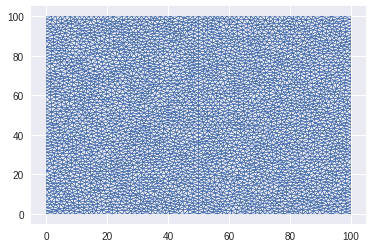

In [106]:
# Create a wrapper for contents of sww file
swwfile = 'run_pump.sww'
splotter = animate.SWW_plotter(swwfile);

plt.triplot(splotter.triang, linewidth = 0.4);

In [107]:
# plot stage
splotter.triang.set_mask(None)
for i,time in enumerate(splotter.time):
  print time
  splotter.save_stage_frame(i)
  
splotter.make_stage_animation()

0.0
2.0
4.0
6.0
8.0
10.0
12.0
14.0
16.0
18.0
20.0
22.0
24.0
26.0
28.0
30.0
32.0
34.0
36.0
38.0
40.0
42.0
44.0
46.0
48.0
50.0
52.0
54.0
56.0
58.0
60.0


## 3D visualisation

We can use the `mpl` module to produce some 3D plots. We need to create vertex values given the centroid values.

This code produes an extra extraneous plot (any suggestion to fix that welcome).



(31, 1246)


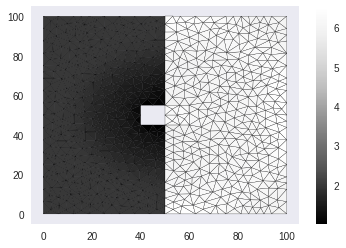

In [72]:
plt.tripcolor(splotter.triang, 
              facecolors = splotter.stage[3], 
              edgecolors='k', 
              cmap='Greys_r')
plt.colorbar();




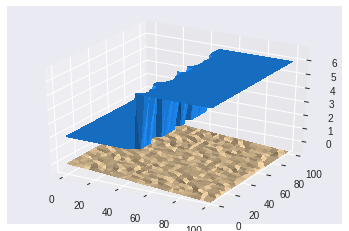

In [6]:

X = np.vstack((splotter.xc, splotter.yc)).transpose()
E = splotter.elev

splotter.nodes = np.vstack((splotter.x,splotter.y)).transpose()
import scipy

stage_v = []
for i,S in enumerate(splotter.stage):
  #print i, S.shape, X.shape
  Interp = scipy.interpolate.NearestNDInterpolator(X,S)
  stage_v.append(Interp(splotter.nodes))
  
stage_v = np.array(stage_v)

Interp = scipy.interpolate.NearestNDInterpolator(X,E)
elev_v = Interp(splotter.nodes)


from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D


fig = plt.figure()
#fig, ax = plt.subplots()
ax = plt.gca(projection='3d')

def update_image(i):
    ax.clear()
    ax.plot_trisurf(splotter.triang, elev_v, color='navajowhite', edgecolors='none', antialiased=False, shade=True)
    ax.plot_trisurf(splotter.triang, stage_v[i*step], color='dodgerblue', edgecolors='none', alpha=1.0, linewidth=0, antialiased=False, shade=True)
    ax.set_zlim(elev_v.min(), np.max([stage_v.max(), elev_v.max()]))
    

# increase step to skip frames; increase interval to increase movie speed
step = 4
anim = animation.FuncAnimation(fig, update_image, frames=len(splotter.depth)/step, interval=20);

anim

## Examine elevation at points

As in the previous notebook, it is instructive to examine the value of the quantity of interest at specific locations. 

In [0]:
# Alias
xc = splotter.xc
yc = splotter.yc

# Observation points across the first step
point_observations = [[125.3, 0.0], 
                      [125.3, 0.5], 
                      [125.3, 1.0], 
                      [125.3, 1.5],
                      [125.3, 2.0],
                      [125.3, 2.5],
                     ]

# Find nearest centroid to observation points
nearest_points = []
for row in point_observations:
    nearest_points.append(np.argmin( (xc-row[0])**2 + (yc-row[1])**2 ))
    
fig, ax = plt.subplots()

for i, npt in enumerate(nearest_points):
  ax.plot(splotter.time, splotter.elev[:,npt], label=str(point_observations[i][1]) )

ax.legend(loc = 'center right')
plt.title('Elevation')
plt.xlabel('time')
plt.ylabel('height')




print nearest_points
 